# Time Series Prediction


## Introduction

Predicting time series data is useful for a variety of business applications. Companies forecast time series data in order to forecast sales, manage their supply chains, and more.

LSTMs are commonly used for time series prediction because they are able to learn the underlying patterns of time series data. 

In this exercise, we will use an LSTM to forecast the data from a random timeseries by training it on the timeseries.

## Instructions

You can begin forecasting trends with LSTMs with the following steps:

1. Generate your timeseries data in Numpy
2. Load the data into PyTorch
3. Train your model on the data
4. Run the model to predict the next steps in the time series.

<b> Generate X, Y data </b>

In [1]:
# create a sinusoidal dataset
import numpy as np
X = np.arange(100)
Y = np.array([np.sin(x/10) + 0.01*x for x in X])

# create a sinusoidal dataset 6 steps in the future
X_p = np.arange(6, 100+6)
Y_p = np.array([np.sin(x/10) + 0.01*x for x in X_p])

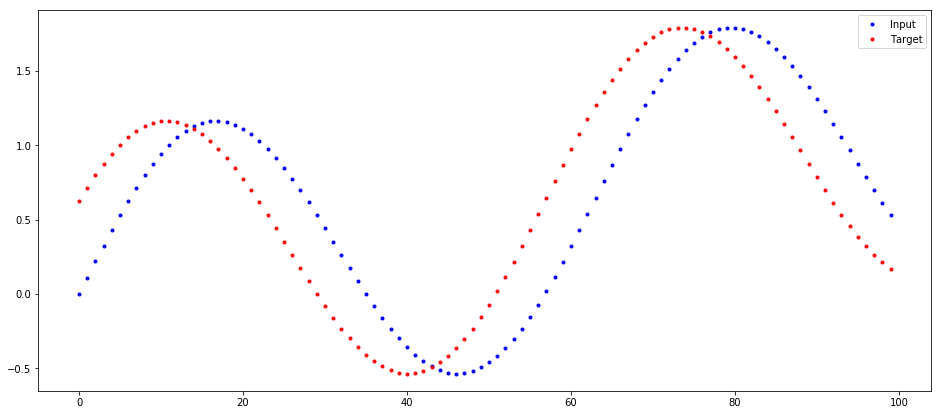

In [2]:
# Visualize graph
import matplotlib.pyplot as plt
%matplotlib inline

plt.figure(figsize=[16, 7])
plt.plot(X, Y, 'b.', label="Input")
plt.plot(X, Y_p, 'r.', label="Target")
plt.legend(loc="best")
plt.show()

<b> Create an LSTM Model using nn.LSTMCell (Wraps in loops) </b>

In [3]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt

In [4]:
class LSTM_1(nn.Module):
    
    def __init__(self, hidden_size, seq_length):
        super(LSTM_1, self).__init__()
        
        self.seq_length = seq_length
        
        # define 1 LSTM cell which can be used multiple times in the forward method
        self.lstm = nn.LSTMCell(input_size=1, hidden_size=hidden_size)
        
        # to predict a specific value for the next time step, output size of the fc layer should be 1
        self.fc = nn.Linear(hidden_size, 1)
        
    def forward(self, x, hidden, cell):
        
        # repeat the LSTM cell for times equal to the sequence length
        for i in range(self.seq_length):
            
            # since a LSTMCell only take in one value in the input sequence, each value in x is fed sequentially into each LSTMCell
            # unsqueeze is applied twice to give the input to LSTMCell a shape of (1, 1)
            hidden, cell = self.lstm(x[i].unsqueeze(0).unsqueeze(0), (hidden, cell))
            
            # input's size = (batch size, input size) = (1, 1)
            # hidden's size = (batch size, input size) = (1, 1)
            # cell's size = (batch size, input size) = (1, 1)
            
            output = self.fc(hidden) if i == 0 else torch.cat((output, self.fc(hidden)), dim=0)
        
        return output, hidden, cell

In [5]:
hidden_size = 32
seq_length = 10
pred_steps = 3
i = 0

# test that the dimensions are as expected
test_lstm = LSTM_1(hidden_size, seq_length)

# generate test data points and convert to Tensors
time_steps = np.arange(i*seq_length, (i+1)*seq_length)
time_steps_pred = np.arange(i*seq_length+pred_steps, (i+1)*seq_length+pred_steps)
data = np.array([np.sin(x/10) + 0.01*x for x in time_steps])
data_pred = np.array([np.sin(x/10) + 0.01*x for x in time_steps_pred])
x_tensor = torch.Tensor(data)
y_tensor = torch.Tensor(data_pred).unsqueeze(1)

# initialize cell state and hidden state
init_hidden = torch.zeros(1, hidden_size)
init_cell = torch.zeros(1, hidden_size)

# test lstm sizes
test_out = test_lstm(x_tensor, init_hidden, init_cell)
print('Input size: ', x_tensor.size())
print('Target size: ', y_tensor.size())
print('Output size: ', test_out[0].size()) # the forward function returns output, hidden state and cell state, we only need the output

Input size:  torch.Size([10])
Target size:  torch.Size([10, 1])
Output size:  torch.Size([10, 1])


In [6]:
# define training loop (version 1) for the LSTM
def train_1(lstm, n_steps, print_every, seq_length, pred_steps, hidden_size):

    # initialize cell state and hidden state
    hidden = torch.zeros(1, hidden_size)
    cell = torch.zeros(1, hidden_size)
    
    for i in range(n_steps):
        
        # define training data and convert to Tensors
        time_steps = np.arange(i*seq_length, (i+1)*seq_length)
        time_steps_pred = np.arange(i*seq_length+pred_steps, (i+1)*seq_length+pred_steps)
        
        # use a simplified version of the sinusoidal formula without systematic trends
        data = np.array([np.sin(x/10) for x in time_steps])
        data_pred = np.array([np.sin(x/10) for x in time_steps_pred])
        
        x_tensor = torch.Tensor(data)
        y_tensor = torch.Tensor(data_pred).unsqueeze(1)
        
        # get output from lstm
        prediction, hidden, cell = lstm(x_tensor, hidden, cell)
        
        # make a new variable for hidden and detach the hidden state from its history
        # this way, we don't backpropagate through the entire history
        hidden, cell = hidden.data, cell.data        
        
        # calculate loss
        loss = criterion(prediction, y_tensor)
        
        # zero out gradients
        optimizer.zero_grad()
        
        # perform backprop and update weights 
        loss.backward()
        optimizer.step()
        
        # display loss and predictions
        if i % print_every == 0:        
            print('Cell state avg. value: ', torch.mean(cell).item())
            print('Hidden state avg. value: ', torch.mean(hidden).item())
            print('Loss: ', loss.item())
            plt.figure(figsize=(10, 5))
            plt.plot(time_steps, x_tensor.data.numpy(), 'b.', label="Input") # input
            plt.plot(time_steps, y_tensor.data.numpy(), 'g.', label="Target") # target
            plt.plot(time_steps, prediction.data.numpy(), 'r.', label="Prediction") # prediction
            plt.legend(loc="best")
            plt.show()
    
    return lstm

# define training loop (version 2) for the LSTM
def train_2(lstm, n_steps, print_every, seq_length, pred_steps, hidden_size):

    # initialize cell state and hidden state
    hidden = torch.zeros(1, hidden_size)
    cell = torch.zeros(1, hidden_size)
    
    for i in range(n_steps):
        
        # define training data and convert to Tensors
        time_steps = np.arange(i*seq_length, (i+1)*seq_length)
        time_steps_pred = np.arange(i*seq_length+pred_steps, (i+1)*seq_length+pred_steps)
        
        # use the original sinusoidal formula with systematic trends
        data = np.array([np.sin(x/10) + 0.01*x for x in time_steps])
        data_pred = np.array([np.sin(x/10) + 0.01*x for x in time_steps_pred])
        
        x_tensor = torch.Tensor(data)
        y_tensor = torch.Tensor(data_pred).unsqueeze(1)
        
        # get output from lstm
        prediction, hidden, cell = lstm(x_tensor, hidden, cell)
        
        # make a new variable for hidden and detach the hidden state from its history
        # this way, we don't backpropagate through the entire history
        hidden, cell = hidden.data, cell.data        
        
        # calculate loss
        loss = criterion(prediction, y_tensor)
        
        # zero out gradients
        optimizer.zero_grad()
        
        # perform backprop and update weights 
        loss.backward()
        optimizer.step()
        
        # display loss and predictions
        if i % print_every == 0:        
            print('Cell state avg. value: ', torch.mean(cell).item())
            print('Hidden state avg. value: ', torch.mean(hidden).item())
            print('Loss: ', loss.item())
            plt.figure(figsize=(10, 5))
            plt.plot(time_steps, x_tensor.data.numpy(), 'b.', label="Input") # input
            plt.plot(time_steps, y_tensor.data.numpy(), 'g.', label="Target") # target
            plt.plot(time_steps, prediction.data.numpy(), 'r.', label="Prediction") # prediction
            plt.legend(loc="best")
            plt.show()
    
    return lstm

In [7]:
# decide hyperparameters
hidden_size = 32
seq_length = 40
pred_steps = 20

# initiate a LSTM
lstm_1 = LSTM_1(hidden_size, seq_length)

# define loss and optimizer
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(lstm_1.parameters(), lr=0.01)

# train the LSTM and monitor results
n_steps = 1000
print_every = 200

Cell state avg. value:  0.005687803030014038
Hidden state avg. value:  0.004885830916464329
Loss:  0.6389470100402832


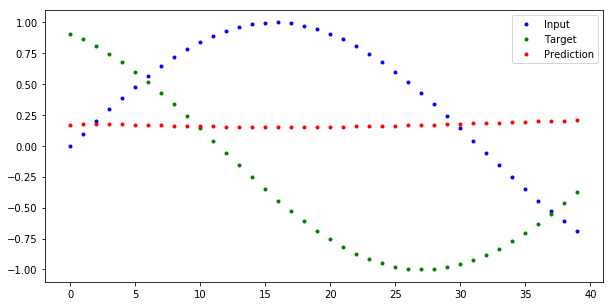

Cell state avg. value:  -0.19645902514457703
Hidden state avg. value:  -0.07325519621372223
Loss:  0.0005152052617631853


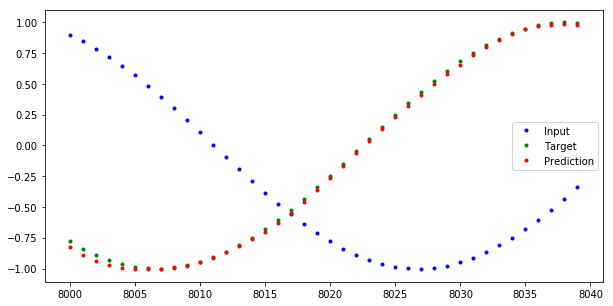

Cell state avg. value:  0.10578778386116028
Hidden state avg. value:  0.04778800532221794
Loss:  0.00010206697334069759


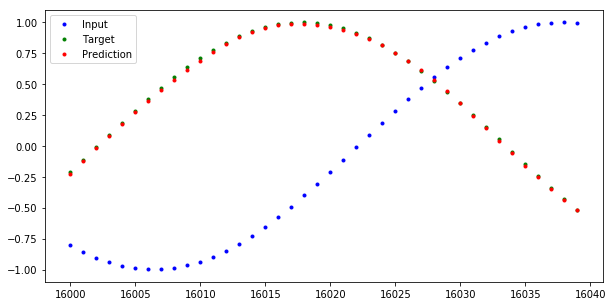

Cell state avg. value:  0.2594061493873596
Hidden state avg. value:  0.06680908054113388
Loss:  0.0007473351433873177


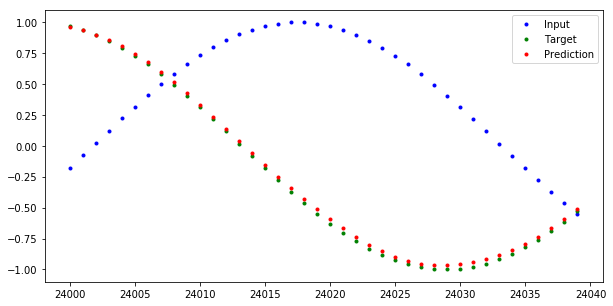

Cell state avg. value:  -0.25235626101493835
Hidden state avg. value:  -0.08598759025335312
Loss:  0.00048714177682995796


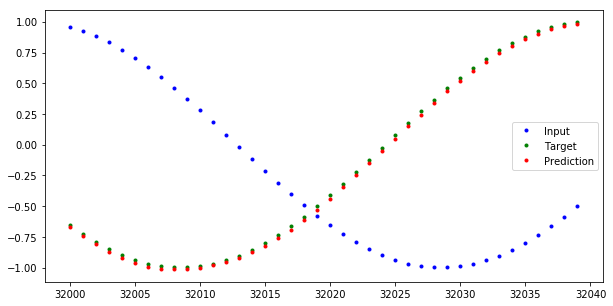

In [8]:
# train using training loop version 1
_ = train_1(lstm_1, n_steps, print_every, seq_length, pred_steps, hidden_size)

Cell state avg. value:  0.3873719871044159
Hidden state avg. value:  0.08467058092355728
Loss:  0.7082862854003906


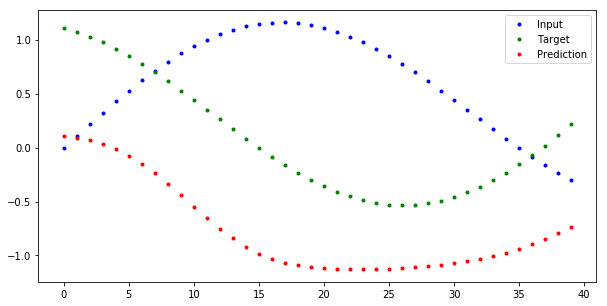

Cell state avg. value:  306.90545654296875
Hidden state avg. value:  0.15625005960464478
Loss:  0.8039047122001648


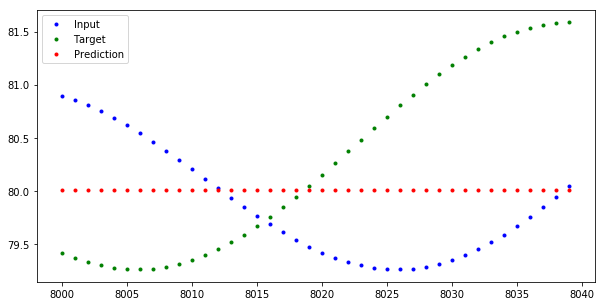

Cell state avg. value:  812.9847412109375
Hidden state avg. value:  0.15625
Loss:  1.3179208040237427


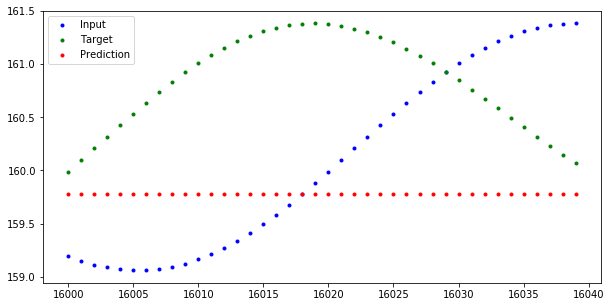

Cell state avg. value:  1478.6204833984375
Hidden state avg. value:  0.15625
Loss:  0.6342426538467407


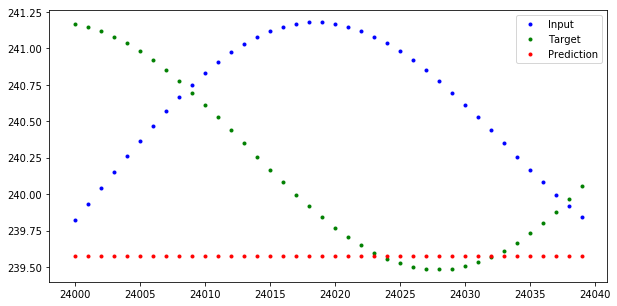

Cell state avg. value:  2194.2177734375
Hidden state avg. value:  0.15625
Loss:  1.4258489608764648


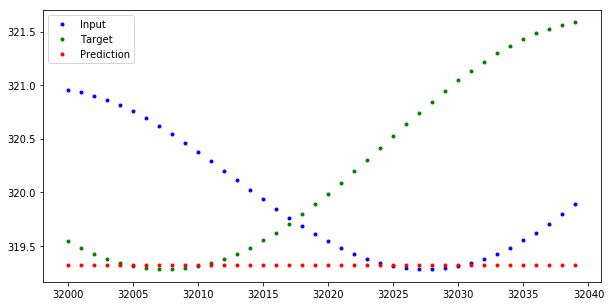

In [10]:
# train using training loop version 2
_ = train_2(lstm_1, n_steps, print_every, seq_length, pred_steps, hidden_size)

<b> Create an LSTM Model using nn.LSTM </b>

In [11]:
class LSTM_2(nn.Module):
    
    def __init__(self, hidden_size, num_layers):
        super(LSTM_2, self).__init__()
         
        # define 1 LSTM cell which can be used multiple times in the forward method
        self.lstm = nn.LSTM(input_size=1, hidden_size=hidden_size, num_layers=num_layers, batch_first=True)
        
        # to predict a specific value for the next time step, output size of the fc layer should be 1
        self.fc = nn.Linear(hidden_size, 1)
        
    def forward(self, x, hidden, cell):

        output, (hidden, cell) = self.lstm(x, (hidden, cell))

        # input's size = (batch size, seq_length, input_size)
        # hidden's size = (num_layers, batch size, hidden_size)
        # cell's size = (num_layers, batch size, hidden_size)
        # output's size = (batch size, seq_length, hidden_size)

        output = self.fc(output)
        
        # output's size = (batch size, seq_length, 1)
        
        return output, hidden, cell

In [12]:
hidden_size = 32
seq_length = 10
pred_steps = 3
i = 0

# test that the dimensions are as expected
test_lstm = LSTM_2(hidden_size, num_layers=1)

# generate test data points and convert to Tensors
time_steps = np.arange(i*seq_length, (i+1)*seq_length)
time_steps_pred = np.arange(i*seq_length+pred_steps, (i+1)*seq_length+pred_steps)
data = np.array([np.sin(x/10) + 0.01*x for x in time_steps])
data_pred = np.array([np.sin(x/10) + 0.01*x for x in time_steps_pred])
x_tensor = torch.Tensor(data).unsqueeze(1).unsqueeze(0)
y_tensor = torch.Tensor(data_pred).unsqueeze(1).unsqueeze(0)

print('Input size: ', x_tensor.size())
print('Target size: ', y_tensor.size())

# initialize cell state and hidden state
hidden = torch.zeros(1, 1, hidden_size)
cell = torch.zeros(1, 1, hidden_size)

# test lstm sizes
test_out, hidden, cell = test_lstm(x_tensor, hidden, cell)

print('Output size: ', test_out.size()) # the forward function returns output, hidden state and cell state, we only need the output

Input size:  torch.Size([1, 10, 1])
Target size:  torch.Size([1, 10, 1])
Output size:  torch.Size([1, 10, 1])


In [17]:
# define training loop (version 3) for the LSTM
def train_3(lstm, n_steps, print_every, seq_length, pred_steps, hidden_size, num_layers):

    # initialize cell state and hidden state
    hidden = torch.zeros(num_layers, 1, hidden_size)
    cell = torch.zeros(num_layers, 1, hidden_size)
    
    for i in range(n_steps):
        
        # define training data and convert to Tensors
        time_steps = np.arange(i*seq_length, (i+1)*seq_length)
        time_steps_pred = np.arange(i*seq_length+pred_steps, (i+1)*seq_length+pred_steps)
        
        # use the original sinusoidal formula with systematic trends
        data = np.array([np.sin(x/10) + 0.01*x for x in time_steps])
        data_pred = np.array([np.sin(x/10) + 0.01*x for x in time_steps_pred])
        
        x_tensor = torch.Tensor(data).unsqueeze(1).unsqueeze(0)
        y_tensor = torch.Tensor(data_pred).unsqueeze(1).unsqueeze(0)
        
        # get output from lstm
        prediction, hidden, cell = lstm(x_tensor, hidden, cell)
        
        # make a new variable for hidden and detach the hidden state from its history
        # this way, we don't backpropagate through the entire history
        hidden, cell = hidden.data, cell.data        
        
        # calculate loss
        loss = criterion(prediction, y_tensor)
        
        # zero out gradients
        optimizer.zero_grad()
        
        # perform backprop and update weights 
        loss.backward()
        optimizer.step()
        
        # display loss and predictions
        if i % print_every == 0:        
            print('Cell state avg. value: ', torch.mean(cell).item())
            print('Hidden state avg. value: ', torch.mean(hidden).item())
            print('Loss: ', loss.item())
            plt.figure(figsize=(10, 5))
            plt.plot(time_steps, x_tensor.data.numpy().flatten(), 'b.', label="Input") # input
            plt.plot(time_steps, y_tensor.data.numpy().flatten(), 'g.', label="Target") # target
            plt.plot(time_steps, prediction.data.numpy().flatten(), 'r.', label="Prediction") # prediction
            plt.legend(loc="best")
            plt.show()
    
    return lstm

In [15]:
# decide hyperparameters
hidden_size = 32
num_layers = 2
seq_length = 20
pred_steps = 10

# initiate a LSTM
lstm_2 = LSTM_2(hidden_size, num_layers)

# define loss and optimizer
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(lstm_2.parameters(), lr=0.01)

# train the LSTM and monitor results
n_steps = 1000
print_every = 200

Cell state avg. value:  -0.019612804055213928
Hidden state avg. value:  -0.010457934811711311
Loss:  0.7258071899414062


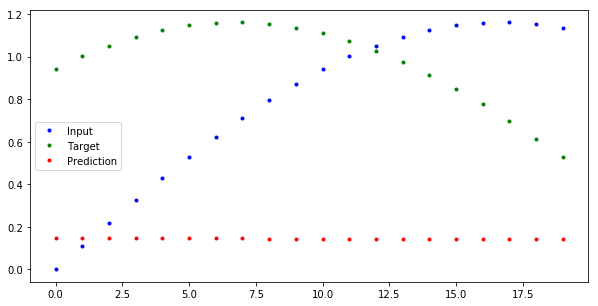

Cell state avg. value:  -87.32209777832031
Hidden state avg. value:  0.07836668193340302
Loss:  0.4007774293422699


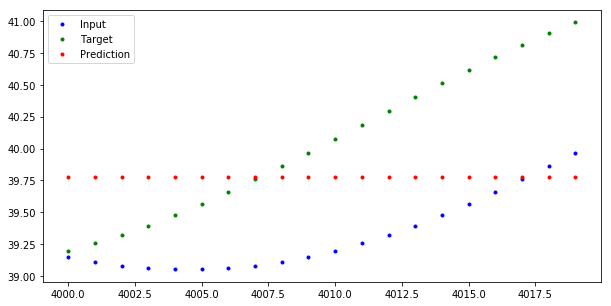

Cell state avg. value:  -138.6411590576172
Hidden state avg. value:  0.07821434736251831
Loss:  0.13581885397434235


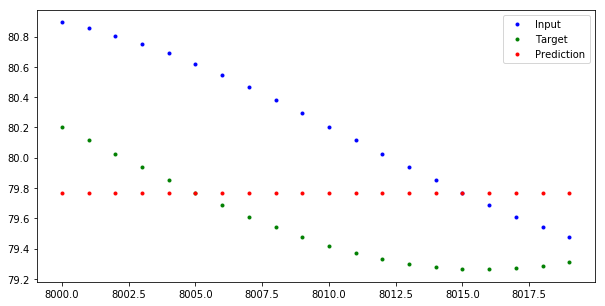

Cell state avg. value:  -140.3309326171875
Hidden state avg. value:  0.07815238833427429
Loss:  1.6218788623809814


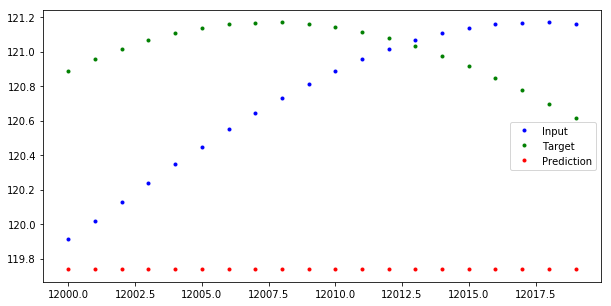

Cell state avg. value:  -144.85604858398438
Hidden state avg. value:  0.07813473790884018
Loss:  0.36775481700897217


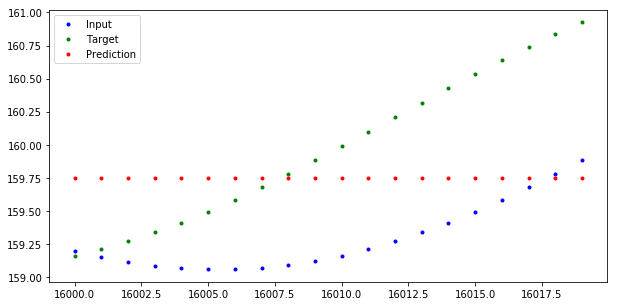

In [18]:
# train using training loop version 2
_ = train_3(lstm_2, n_steps, print_every, seq_length, pred_steps, hidden_size, num_layers)